# Behavioral Clonning
The goal of the following project is to develop a deep neural network to learn how to drive a simulated car.

## Load Images

This file pre process the data image and CSV generated by the simulator. Udacity provided a data package, which can be download in [this link](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip) containing the following files:
* Folder with 8.036 simulation images, showing the center, left and right camera view of the road, totalizing 24.108 images
* File <em>driving\_log.csv</em> containing a list describing all the images
    * Center image path
    * Left image path
    * Right image path
    * Steering angle
    * Throttle
    * Brake
    * Speed

Bellow are some examples of the images provided by Udacity and how it is shown in the _csv_ file:


IMG/center_2016_12_01_13_30_48_287.jpg, IMG/left_2016_12_01_13_30_48_287.jpg, IMG/right_2016_12_01_13_30_48_287.jpg, 0, 0, 0, 22.14829

* Center image path - IMG/center_2016_12_01_13_30_48_287.jpg
* Left image path - IMG/left_2016_12_01_13_30_48_287.jpg
* Right image path - IMG/right_2016_12_01_13_30_48_287.jpg
* Steering angle - 0
* Throttle - 0
* Brake - 0
* Speed - 22.14829


In [1]:
'''
    Read driving_log.csv and save it in a vector with the following configuration:
        * Image path
        * Steering angle
        * Throttle
        * Brake
        * Speed
'''

import csv

list_images = list()

# The following value is added and subtracted from the steering angle for the images of the right and left side of the car
offset = 0.1

with open('data\driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        steering = float(row[3])
        throttle = float(row[4])
        brake = float(row[5])
        speed = float(row[6])
        # Center image
        list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
        # Left image
        list_images.append([row[1].replace(" ", ""), steering + offset, throttle, brake, speed])
        # Right image
        list_images.append([row[2].replace(" ", ""), steering - offset, throttle, brake, speed])
        
print('Images mapped with {} examples'.format(len(list_images)))

Images mapped with 24108 examples


### Ploting histogram
In order to analyze the angles distribution of our dataset, a histogram is plotted bellow. Here is possible to see that a higher number of small steerings is presented in the dataset, with a higher number of three especific angle band.

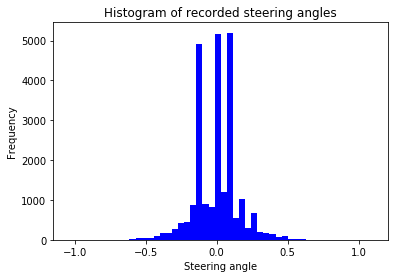

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

histogram = [x[1] for x in list_images]

plt.hist(histogram, 50, facecolor='blue');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

## Image Augmentation
In order to generate more data without the necessity of collectiong it, it is possible to apply some transformations.

In [26]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random
%matplotlib inline

def plot_image_prob(image):
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(111)
    ax.imshow(image, vmin=0, vmax=255)
    plt.axis('off')
    ax.axis('tight')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

def flip_image(img, steering):
    if random.randint(0, 1):
        return cv2.flip(img, 1), -steering
    else:
        return img, steering
    
def brightness_image(img, steering):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def rotate_image(img, steering):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(img,M,(cols,rows)), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

# example = list_images[random.randint(0,len(list_images))]
# image = Image.open("data/" + example[0])
# print("Original shape: {}".format(image.size))
# new_image, new_steering = rotate_image(np.copy(image), example[1])
# cutted_image = cut_image(new_image)
# print("New shape: {}".format(cutted_image.shape))
# print("Old steering: {}".format(example[1]))
# print("New steering: {}".format(new_steering))
# plot_image_prob(image)
# plot_image_prob(new_image)
# plot_image_prob(cutted_image)

## Load the data
The data will not be entirely loaded to the memory because the dataset is too big, so a function *load_data* is created in order to load the data as it is needed.

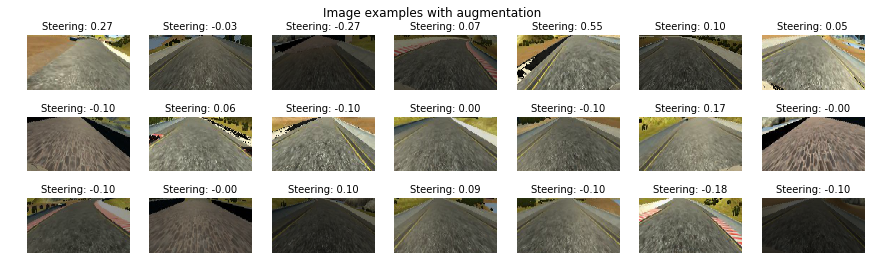

In [68]:
def load_data(list_images, indices):
    # Placeholders for the images and labels from web
    X_train = np.empty(shape = [1, 288, 72, 3], dtype = np.uint8)
    y_train = np.empty(shape = [1], dtype = np.float32)

    for i in indices:
        image = Image.open("data/" + list_images[i][0])
        steering = list_images[i][1]
        
        image, steering = flip_image(np.copy(image), steering)
        image, steering = brightness_image(np.copy(image), steering)
        image, steering = rotate_image(np.copy(image), steering)
        image = cut_image(image)

        X_train = np.vstack([X_train, np.reshape(image, [1, 288, 72, 3])])
        y_train = np.vstack([y_train, steering]) 
    
    # Get rid of the first empty row
    X_train = X_train[1:, :, :, :]
    y_train = y_train[1:]

    return X_train, y_train

# num_images = len(list_images)
# rows = 160
# cols = 320
# channels = 3

# print(num_images)
# print(rows)
# print(cols)
# print(channels)

# X_train_raw = np.zeros((5000,rows,cols,channels))
# for i in range(len(list_images)):
#     img = plt.imread("data/" + list_images[i][0])
#     X_train_raw[i,:,:,:] = img

from random import randint

indices = random.sample(range(0, len(list_images)), 21)
X_train, y_train = load_data(list_images, indices)
                
# Plot an example of images processed
fig = plt.figure(facecolor="white");
fig.set_size_inches(15, 4);
fig.subplots_adjust(hspace=.5);

for i in range(21):    
    ax=fig.add_subplot(3, 7, i+1);    
    ax.imshow(np.reshape(X_train[i], [72, 288, 3]), vmin=0, vmax=255);
    ax.axis('off');
    ax.set_title("Steering: {0:.2f}".format(y_train[i][0]), fontsize = 10);
    ax.axis('tight');
plt.suptitle('Image examples with augmentation');

## Neural network implementation
Bellow will be implemented the network network, which is based on the paper released by NVIDIA.

In [90]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Activation, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

model = Sequential()

# Input image: 72, 288

model = Sequential()

# Layer 1: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(24, 5, 5, input_shape=(66, 200, 3), border_mode='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

# Layer 2: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(36, 5, 5))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(48, 5, 5))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

# Layer 4: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))

# Layer 5: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(p=0.5))
model.add(Dense(50))
model.add(Dropout(p=0.5))
model.add(Dense(10))
model.add(Dropout(p=0.5))
model.add(Dense(1))

print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_56 (Convolution2D) (None, 66, 200, 24)   1824        convolution2d_input_20[0][0]     
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 66, 200, 24)   0           convolution2d_56[0][0]           
____________________________________________________________________________________________________
maxpooling2d_46 (MaxPooling2D)   (None, 33, 100, 24)   0           activation_49[0][0]              
____________________________________________________________________________________________________
convolution2d_57 (Convolution2D) (None, 29, 96, 36)    21636       maxpooling2d_46[0][0]            
___________________________________________________________________________________________

In [ ]:

# model.add(Dropout(0.5))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dense(43))
# model.add(Activation('softmax'))

# #scale image from 160x320 to 80x160
# # model.add(Convolution2D(nb_row=1, nb_col=1, border_mode='valid', 
# #                         nb_filter=3, init='normal',
# #                        subsample=(5,5), input_shape=(72, 288, 3),
# #                         name='subsample'))
# # 5x5 with 2x2 striding          
# model.add(Convolution2D(nb_row=5, nb_col=5, border_mode='valid', 
#                         nb_filter=24,
#                         input_shae=(72,288,3),
#                            activation='relu',
#                           init='normal'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# model.add(Convolution2D(nb_row=5, nb_col=5, border_mode='valid', 
#                         nb_filter=36,
#                            activation='relu',
#                           init='normal'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(BatchNormalization())

# # Nvidia model includes 3rd conv layer, which we don't use
# # model.add(Convolution2D(nb_row=5, nb_col=5, border_mode='same', 
# #                         nb_filter=48,
# #                            activation='relu', subsample=(4,4), 
# #                           init='normal'))
# # model.add(BatchNormalization())

# # 3x3 with no striding
# model.add(Convolution2D(nb_row=3, nb_col=3, border_mode='valid', 
#                         nb_filter=64,
#                            activation='relu',  
#                           init='normal'))
# model.add(BatchNormalization())

# model.add(Convolution2D(nb_row=3, nb_col=3, border_mode='valid', 
#                         nb_filter=64,
#                            activation='relu',  
#                           init='normal'))
# model.add(BatchNormalization())

# model.add(Flatten(name='flatten'))

# model.add(Dense(output_dim=1164, init='normal', activation='relu'))
# model.add(Dropout(p=0.5))
# model.add(BatchNormalization())

# model.add(Dense(output_dim=100, init='normal', activation='relu'))
# model.add(Dropout(p=0.5))
# model.add(BatchNormalization())

# model.add(Dense(output_dim=50, init='normal', activation='relu'))
# model.add(Dropout(p=0.5))
# model.add(BatchNormalization())

# model.add(Dense(output_dim=10, init='normal', activation='relu'))
# model.add(Dropout(p=0.5))
# model.add(BatchNormalization())

# model.add(Dense(output_dim=1, name='output', init='normal'))